In [1]:
!pip install wordcloud

In [2]:
!pip install rouge_score

In [3]:
!pip install simplet5 -q

In [4]:
pip install -U transformers tokenizers

  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.16.2
    Uninstalling transformers-4.16.2:
      Successfully uninstalled transformers-4.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simplet5 0.1.4 requires transformers==4.16.2, but you have transformers 4.26.0 which is incompatible.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.26.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip --no-cache-dir install nlpaug

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install nltk

In [7]:
import gc
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw

In [8]:
train_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
test_df  = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')
valid_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')

In [11]:
print(f"train_df.shape: {train_df.shape}")
print(f"test_df.shape: {test_df.shape}")
print(f"valid_df.shape: {valid_df.shape}")

train_df.shape: (287113, 3)
test_df.shape: (11490, 3)
valid_df.shape: (13368, 3)


In [12]:
train_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [15]:
#Check Nulls

train_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

In [16]:
#Check Duplicates

train_df.duplicated(subset= ['article', 'highlights']).sum()

3098

In [19]:
#Drop Duplicates

train_df = train_df.drop_duplicates(subset= ['article', 'highlights'])
train_df.shape

(284015, 3)

In [23]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenization(text):
    return word_tokenize(text)

print(tokenization(train_df['article'][0]))

['By', '.', 'Associated', 'Press', '.', 'PUBLISHED', ':', '.', '14:11', 'EST', ',', '25', 'October', '2013', '.', '|', '.', 'UPDATED', ':', '.', '15:36', 'EST', ',', '25', 'October', '2013', '.', 'The', 'bishop', 'of', 'the', 'Fargo', 'Catholic', 'Diocese', 'in', 'North', 'Dakota', 'has', 'exposed', 'potentially', 'hundreds', 'of', 'church', 'members', 'in', 'Fargo', ',', 'Grand', 'Forks', 'and', 'Jamestown', 'to', 'the', 'hepatitis', 'A', 'virus', 'in', 'late', 'September', 'and', 'early', 'October', '.', 'The', 'state', 'Health', 'Department', 'has', 'issued', 'an', 'advisory', 'of', 'exposure', 'for', 'anyone', 'who', 'attended', 'five', 'churches', 'and', 'took', 'communion', '.', 'Bishop', 'John', 'Folda', '(', 'pictured', ')', 'of', 'the', 'Fargo', 'Catholic', 'Diocese', 'in', 'North', 'Dakota', 'has', 'exposed', 'potentially', 'hundreds', 'of', 'church', 'members', 'in', 'Fargo', ',', 'Grand', 'Forks', 'and', 'Jamestown', 'to', 'the', 'hepatitis', 'A', '.', 'State', 'Immunizatio

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
from nltk.stem import WordNetLemmatizer
def lemmatization(text):
    tokenization = nltk.word_tokenize(text)
    return  WordNetLemmatizer.lemmatize(text)
print(tokenization(train_df['article'][0]))


['By', '.', 'Associated', 'Press', '.', 'PUBLISHED', ':', '.', '14:11', 'EST', ',', '25', 'October', '2013', '.', '|', '.', 'UPDATED', ':', '.', '15:36', 'EST', ',', '25', 'October', '2013', '.', 'The', 'bishop', 'of', 'the', 'Fargo', 'Catholic', 'Diocese', 'in', 'North', 'Dakota', 'has', 'exposed', 'potentially', 'hundreds', 'of', 'church', 'members', 'in', 'Fargo', ',', 'Grand', 'Forks', 'and', 'Jamestown', 'to', 'the', 'hepatitis', 'A', 'virus', 'in', 'late', 'September', 'and', 'early', 'October', '.', 'The', 'state', 'Health', 'Department', 'has', 'issued', 'an', 'advisory', 'of', 'exposure', 'for', 'anyone', 'who', 'attended', 'five', 'churches', 'and', 'took', 'communion', '.', 'Bishop', 'John', 'Folda', '(', 'pictured', ')', 'of', 'the', 'Fargo', 'Catholic', 'Diocese', 'in', 'North', 'Dakota', 'has', 'exposed', 'potentially', 'hundreds', 'of', 'church', 'members', 'in', 'Fargo', ',', 'Grand', 'Forks', 'and', 'Jamestown', 'to', 'the', 'hepatitis', 'A', '.', 'State', 'Immunizatio

In [24]:
def article_len(row):
    return len(row['article'].split())

def highlights_len(row):
    return len(row['highlights'].split())

train_df['article_len'] = train_df.apply(lambda r: article_len(r), axis= 1)
train_df['highlights_len'] = train_df.apply(lambda r: highlights_len(r), axis= 1)

In [25]:
train_df.head()

,id,article,highlights,article_len,highlights_len
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...",198,37
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,392,38
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...",808,69
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,531,53
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,580,67


In [28]:
#Check No. Unique values of ids

train_df.id.nunique()

284015

In [31]:
#drop id columns because it has no info

#train_df = train_df.drop('id', axis= 1)
#train_df.head(3)

In [33]:
train_df.describe()

,article_len,highlights_len
count,284015.000000,284015.000000
mean,692.231660,51.649240
std,336.649158,21.342314
min,8.000000,4.000000
25%,443.000000,38.000000
50%,632.000000,49.000000
75%,877.000000,60.000000
max,2347.000000,1296.000000


In [36]:
print('Original Text : ')
print(train_df['article'][0])

print('\n\nSummary Text : ')
print(train_df['highlights'][0])

Original Text : 
By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for

In [39]:
# train_df = train_df.drop('article_len', axis= 1)
# train_df = train_df.drop('highlights_len', axis= 1)
# train_df

In [40]:
all_words = test_df['article'].str.split(expand=True).unstack().value_counts()
 
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

fig.show()

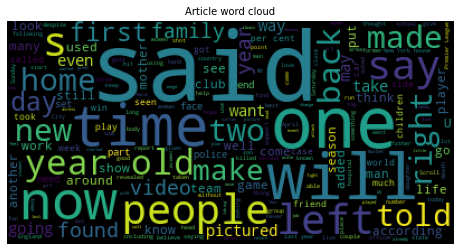

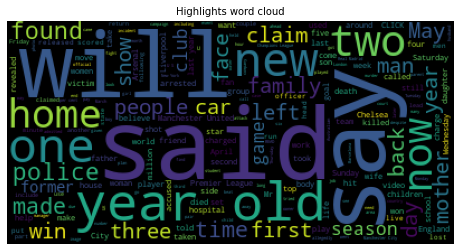

In [41]:
wc = WordCloud(width=400, height=200)

wc.generate(','.join(test_df['article']))
plt.figure(figsize=(8,9))
plt.imshow(wc)
plt.axis('off')
plt.title('Article word cloud', fontdict={'fontsize': 10})

wc.generate(','.join(test_df['highlights']))
plt.figure(figsize=(8,9))
plt.imshow(wc)
plt.axis('off')
plt.title('Highlights word cloud', fontdict={'fontsize': 10})

plt.show()

In [42]:
MAX_LEN = 512
SUMMARY_LEN = 150
TRAINNING_SIZE = 10000

In [43]:
trainning_df = train_df.iloc[0:TRAINNING_SIZE,:].copy()

trainning_article_ls = list(trainning_df['article'])
trainning_highlight_ls = list(trainning_df['highlights'])

del trainning_df

In [44]:
df = pd.DataFrame(columns=['target_text','source_text'])
df['target_text'] = trainning_highlight_ls
df['source_text'] = ['summarize: '+item for item in trainning_article_ls]

In [45]:
from simplet5 import SimpleT5

model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-base")

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5_fast.py:165: FutureWarning:

This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.



In [48]:
MAX_EPOCHS = 12

In [49]:
model.train(train_df=df[0:(int)(0.7*TRAINNING_SIZE)],
            eval_df=df[(int)(0.7*TRAINNING_SIZE):TRAINNING_SIZE], 
            source_max_token_len=MAX_LEN, 
            target_max_token_len=SUMMARY_LEN, 
            batch_size=8, max_epochs=MAX_EPOCHS)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [50]:
model

In [51]:
import os
model_path = ''
rootdir = 'outputs/'
for it in os.scandir(rootdir):
    if it.is_dir():
        if 'simplet5-epoch-'+(str)(MAX_EPOCHS-1) in it.path:
            model_path = it.path
            print(model_path)

outputs/simplet5-epoch-11-train-loss-0.6947-val-loss-1.8589


In [52]:
model.load_model("t5","./"+model_path, use_gpu=True)

In [53]:
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

no_tune_model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

device = torch.device('cpu')

/opt/conda/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning:

This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.



In [54]:


print('Original Text : ')
print(trainning_article_ls[0])

print('\n\nSummary Text : ')
target_text = trainning_highlight_ls[0]
print(target_text)

print('\n\nFine tuned Predicted Summary Text : ')
predicted_text = model.predict(trainning_article_ls[0])
print(predicted_text)
    
print('\n\nNot Fine tuned Predicted Summary Text : ')
preprocess_text = trainning_article_ls[0].strip().replace("\n","")
t5_prepared_Text = "summarize: "+preprocess_text
tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
summary_ids = no_tune_model.generate(tokenized_text,
                                        num_beams=4,
                                        no_repeat_ngram_size=2,
                                        min_length=30,
                                        max_length=SUMMARY_LEN,
                                        early_stopping=True)
output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(output) 
print('===========================================================================================================\n\n')

Original Text : 
By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for

In [55]:
predicted_text = predicted_text[0]

In [58]:
pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [59]:
from rouge import Rouge
rouge = Rouge()    
rouge.get_scores(predicted_text, target_text, avg=True)

{'rouge-1': {'r': 0.42424242424242425,
  'p': 0.358974358974359,
  'f': 0.38888888392361115},
 'rouge-2': {'r': 0.21212121212121213,
  'p': 0.16279069767441862,
  'f': 0.18421052140235472},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3333333333333333,
  'f': 0.3611111061458333}}